In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices, SpectralConnectivity
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [114]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
subj_list = ['015']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];
hand = 'aff'

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'

        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'      
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]

        
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
        
        t_target = int(200+200*1.5)
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,t_target])*100)/Dynmo_odd[i,t_target]
            ERR_value.append(ERR_value1)
      
        over_thres = 20
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>over_thres):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)
        
        epochs_aff_odd_E=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_NE=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_E,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_NE,epochs_aff_typ_NE], method='truncate')
               
        epochs_aff_odd_E.set_channel_types(dict_eog)
        epochs_aff_odd_NE.set_channel_types(dict_eog)
        
        epochs_aff_typ_E.set_channel_types(dict_eog)
        epochs_aff_typ_NE.set_channel_types(dict_eog)


Adding metadata with 9 columns
445 matching events found
No baseline correction applied
Setting up band-pass filter from 0.05 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (66.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_239232\773714269.py:48: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, P8, Pz, T7, T8, TP10, TP9 has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\773714269.py:54: RuntimeWarning: filter_length (13201) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(0.05,30)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks  

Dropped 0 epochs: 
Dropped 134 epochs: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143
Dropped 0 epochs: 
Dropped 102 epochs: 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

In [115]:
"""Average Baseline"""     
def average_baseline(epoch):

    epoch_norm1 =[] 
    for ii,ch in enumerate(epoch.ch_names):
        x = np.hstack(epoch.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)

        x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
        epoch_norm=[]    
        for jj in range(epoch.get_data()[:, ii, :].shape[0]):
            epoch_norm.append(((epoch.get_data()[jj, ii, :]-x_mean))) # applying normalaization on each trail
        epoch_norm1.append(epoch_norm)
    epoch_norm1 = np.array(epoch_norm1)
    epoch_norm1 = np.rollaxis(epoch_norm1,1) # normalized epoch data

    return mne.EpochsArray(epoch_norm1,  epoch.info, events=epoch.events, tmin=epoch.tmin)

def moving_average(x, w):
    x = np.array(x)
    out = []
    if len(x.shape)>1:
        for i in x:
            out.append(np.convolve(i, np.ones(w), 'valid') / w)
        return np.array(out)
    else:
        out.append(np.convolve(x, np.ones(w), 'valid') / w)
        return np.array(out)[0]

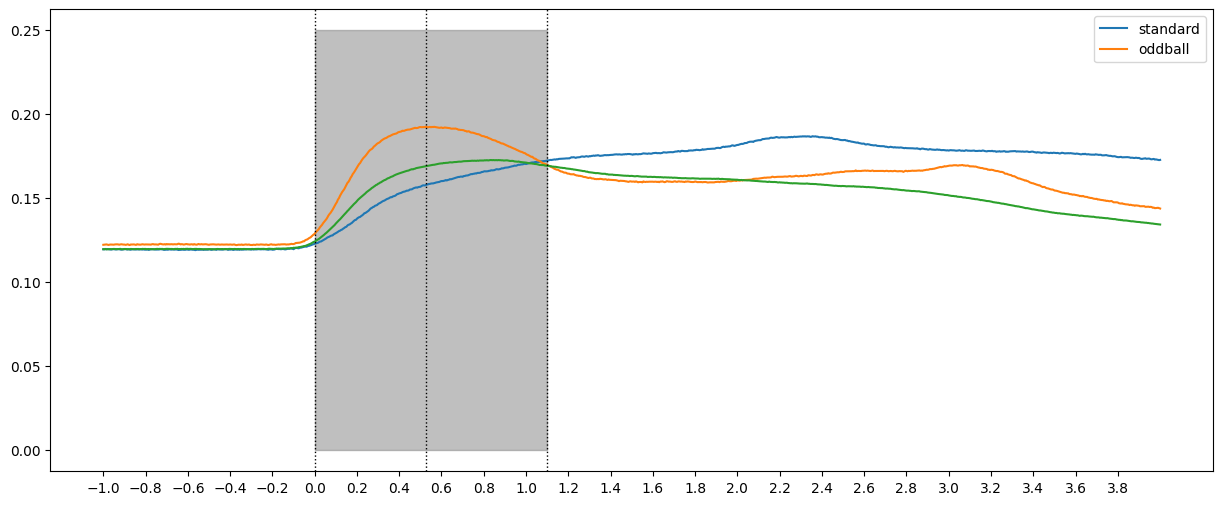

In [116]:
tmin = -1
tmax = 4
Dynmo_odd_E = epochs_aff_odd_E.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_odd_E = Dynmo_odd_E.reshape(Dynmo_odd_E.shape[0],Dynmo_odd_E.shape[2]).mean(axis=0)

Dynmo_odd_NE = epochs_aff_odd_NE.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_odd_NE= Dynmo_odd_NE.reshape(Dynmo_odd_NE.shape[0],Dynmo_odd_NE.shape[2]).mean(axis=0)

Dynmo_typ_E = epochs_aff_typ_E.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_typ_E= Dynmo_typ_E.reshape(Dynmo_typ_E.shape[0],Dynmo_typ_E.shape[2]).mean(axis=0)

plt.figure(figsize=(15,6))

time= epochs_aff_typ.copy().crop(-1,tmax).times

plt.plot(epochs_aff_typ.copy().crop(-1,tmax).times,Dynmo_typ_E)
plt.plot(epochs_aff_odd_E.copy().crop(-1,tmax).times,Dynmo_odd_E)
plt.plot(epochs_aff_odd_NE.copy().crop(-1,tmax).times,Dynmo_odd_NE)

x=np.arange(tmin,tmax,0.2)

plt.xticks(x)

f_max_time = np.argmax(epochs_aff_odd_E.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd_E.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd_E.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200

plt.axvline(0, linewidth=1, color="black", linestyle=":")

plt.axvline(f_max_time, linewidth=1, color="black", linestyle=":")

plt.axvline(1.1, linewidth=1, color="black", linestyle=":")
plt.fill_betweenx(np.array((0,0.25)), 1.1,0,color='gray', alpha=0.5)

plt.legend(['standard','oddball'])


# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time, 0] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5, 1.5] #1.5

In [117]:
# Baseline correction and 

base_min,base_max = -0.9,-0.4
avg = True

if avg == False:
    
    epochs_aff_odd_E = average_baseline(epochs_aff_odd_E)
    epochs_aff_odd_NE = average_baseline(epochs_aff_odd_NE)
    epochs_aff_typ_E = average_baseline(epochs_aff_typ_E)
    epochs_aff_typ_NE = average_baseline(epochs_aff_typ_NE)
else:
    
    epochs_aff_odd_E = epochs_aff_odd_E.apply_baseline((base_min,base_max))
    epochs_aff_odd_NE = epochs_aff_odd_NE.apply_baseline((base_min,base_max))
    epochs_aff_typ_E = epochs_aff_typ_E.apply_baseline((base_min,base_max))
    epochs_aff_typ_NE = epochs_aff_typ_NE.apply_baseline((base_min,base_max))
    


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [118]:
# select ipsilesional channels

seed_chs = epochs_aff_odd_E.copy().pick('dbs').ch_names

ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
#ch_picks = ['FC2', 'FC1', 'Cz', 'Fz', 'CP2', 'CP1', 'Pz']

ch_picks.extend(seed_chs)
epochs_aff_odd_E.pick(ch_picks)
epochs_aff_typ_E.pick(ch_picks)
epochs_aff_odd_NE.pick(ch_picks)
epochs_aff_typ_NE.pick(ch_picks)

Number of events,42
Events,1: 42
Time range,-3.000 – 6.000 s
Baseline,-0.900 – -0.400 s


In [119]:
# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [ 0, f_max_time, 0, 0] #0 # Error detection, Error correction, Full time 0, f_max_time, 0 ,
tmax_coh_lst = [f_max_time, 1.5, 1.1, 1.5] #1.5   f_max_time, 1.5, 1.5, 

In [120]:
""""Coherence"""

# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [ 0, f_max_time, 0, 0] #0 # Error detection, Error correction, Full time 0, f_max_time, 0 ,
tmax_coh_lst = [f_max_time, 1.5, 1.1, 1.5] #1.5   f_max_time, 1.5, 1.5, 

for tmin_coh, tmax_coh in zip(tmin_coh_lst, tmax_coh_lst):

    picks = mne.pick_types(epochs_aff_odd_E.info, eeg=True, dbs=True, emg= False,stim=False, eog=False,
                           exclude='bads')

    epochs_aff_odd_E.pick(['eeg','dbs'])
    epochs_aff_odd_NE.pick(['eeg','dbs'])
    epochs_aff_typ_E.pick(['eeg','dbs'])
    epochs_aff_typ_NE.pick(['eeg','dbs'])
    
    # Use 'DBS' channels as seed
            
    seed_chs = epochs_aff_odd_E.copy().pick('dbs').ch_names
    coh_diff_E = []
    coh_diff_NE = []
    for seed_ch in seed_chs:
        
        picks_ch_names = epochs_aff_odd_E.ch_names
        # Create seed-target indices for connectivity computation
        seed = picks_ch_names.index(seed_ch)
        targets = np.arange(len(picks))
        indices = seed_target_indices(seed, targets)    
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
        min_freq = (4, 8,13,21)
        max_freq = (7, 12,20,30)    
        
        # Define wavelet frequencies and number of cycles
        cwt_freqs = np.arange(1, 41, 1)
        cwt_n_cycles = 7
    
        # Run the connectivity analysis using 2 parallel jobs
        con_odd_E = spectral_connectivity_epochs(
            epochs_aff_odd_E, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        con_typ_E = spectral_connectivity_epochs(
            epochs_aff_typ_E, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)

        con_odd_NE = spectral_connectivity_epochs(
            epochs_aff_odd_NE, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        con_typ_NE = spectral_connectivity_epochs(
            epochs_aff_typ_NE, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
        
        
        times = con_odd_E.times
        freqs = con_odd_E.freqs
    
        # Mark the seed channel with a value of 1.0, so we can see it in the plot
        # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
        # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0
    
        #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
        tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
        tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))

        #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)
    
        tfr_typ_E = mne.time_frequency.AverageTFR(epochs_aff_typ_E.info, con_typ_E.get_data(), times, freqs, len(epochs_aff_typ_E))
        tfr_typ_NE = mne.time_frequency.AverageTFR(epochs_aff_typ_NE.info, con_typ_NE.get_data(), times, freqs, len(epochs_aff_typ_NE))

        #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
        
        # TFR differences in freq bands and time period 0 to 1.5s
    
        tfr_E = tfr_odd_E- tfr_typ_E
        tfr_NE = tfr_odd_NE- tfr_typ_NE

        
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
            
        n_channels = len(tfr_E.copy().pick('eeg').ch_names)
        X1 = []
        X2 = []
        for n, band in enumerate(freq_band):
            tfr_E_ch = []
            tfr_NE_ch = []
            for ch in range(n_channels):
                tfr_E_ch.append((tfr_E.data[:,:,:].mean(axis=2)[ch,n]))
                tfr_NE_ch.append((tfr_NE.data[:,:,:].mean(axis=2)[ch,n]))
    
            tfr_E_ch = np.array(tfr_E_ch).reshape(n_channels,1) 
            tfr_NE_ch = np.array(tfr_NE_ch).reshape(n_channels,1) 
            X1.append(tfr_E_ch)
            X2.append(tfr_NE_ch)
    
        coh_diff_E.append(X1)
        coh_diff_NE.append(X2)
    
    coh_diff_E = np.array(coh_diff_E)
    coh_diff_NE = np.array(coh_diff_NE)
    
    file = f"{base_dir}coh_diff_E_{sub}_{st}_{tmin_coh}_{tmax_coh}_ipsi"
    np.save(file, coh_diff_E)
    
    file = f"{base_dir}coh_diff_NE_{sub}_{st}_{tmin_coh}_{tmax_coh}_ipsi" #ipsi
    np.save(file, coh_diff_NE)

Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:   22.5s remaining:  1.5min
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:   22.6s remaining:   22.6s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:   22.8s remaining:    5.6s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:   22.9s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:   15.5s remaining:  1.0min
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:   16.6s remaining:   16.6s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:   19.1s remaining:    4.7s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:   23.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:   20.9s remaining:    7.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   25.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.0s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.0s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10
[Connectivity computation done]


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users

Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.5s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.4s remaining:    0.0s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.8s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.9s remaining:    0.9s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.5s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10
[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    1.0s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.0s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_o

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.0s finished


    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..0.525s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.0s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 2.120 < 5 cycles based on the epoch length 0.530 sec, need at least 1.250 sec epochs or fmin=9.434. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users

    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(


    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_o

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.0s remaining:    2.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.1s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.4s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    0.0s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.4s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.9s remaining:    0.9s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.7s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.1s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.5s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.3s finished


    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.6s remaining:    1.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.7s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.2s remaining:    0.0s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.525s..1.500s for estimation (196 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 3.920 < 5 cycles based on the epoch length 0.980 sec, need at least 1.250 sec epochs or fmin=5.102. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_o

    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.8s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    1.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    1.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(


    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    2.1s remaining:    0.7s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.5s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.0s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(


    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_o

    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.5s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(


    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.100s for estimation (221 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:177: RuntimeWarning: fmin=4.000 Hz corresponds to 4.420 < 5 cycles based on the epoch length 1.105 sec, need at least 1.250 sec epochs or fmin=4.525. Spectrum estimate will be unreliable.
  warn(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    2.4s remaining:    0.8s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished


[Connectivity computation done]


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished


    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished


    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.7s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.2s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.3s finished


     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.4s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.3s finished


    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.3s finished


     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.1s remaining:    3.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.3s remaining:    0.4s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    2.3s remaining:    4.7s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    2.5s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be remov

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.3s finished


    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.5s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.7s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.1s remaining:    1.1s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.5s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, s

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.6s finished


Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.0s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.2s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    0.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_o

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..10


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done   8 out of  10 | elapsed:    0.4s remaining:    0.0s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.5s remaining:    0.3s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 18 connections
    using t=0.000s..1.500s for estimation (301 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..30


[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    1.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.1s remaining:    3.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    2.2s remaining:    0.7s


    computing cross-spectral density for epochs 31..42


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  12 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=30)]: Done   7 out of  12 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  10 out of  12 | elapsed:    0.9s remaining:    0.1s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  12 out of  12 | elapsed:    1.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:69: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:70: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_NE = mne.time_frequency.AverageTFR(epochs_aff_odd_NE.info, con_odd_NE.get_data(), times, freqs, len(epochs_aff_odd_NE))
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2349117804.py:74: FutureWarning: Para

# Load coherence 

In [121]:
'''

file = file = f"{base_dir}coh_diff_NE_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff_NE = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_NE_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff_NE_permuted= np.load(file)

# Error Detection

file = f"{base_dir}coh_diff_E_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_E_ED = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_E_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_E_permuted_ED= np.load(file)

file = f"{base_dir}coh_diff_NE_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_NE_ED = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_NE_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_NE_permuted_ED = np.load(file)

#Error Correction

file = f"{base_dir}coh_diff_E_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_E_EC = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_E_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_E_permuted_EC= np.load(file)

file = f"{base_dir}coh_diff_NE_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_NE_EC = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_NE_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_NE_permuted_EC = np.load(file)


file f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_ED = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_permuted_ED= np.load(file)

file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_EC = np.load(file)  # Error Correction file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_permuted_EC= np.load(file)


file = f"{base_dir}coh_diff_E_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff_E_ED_EC = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_E_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff_E_permuted_ED_EC= np.load(file)


file = f"{base_dir}coh_diff_E_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[3]}_center.npy"
coh_diff_E = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_E_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[3]}_center.npy"
coh_diff_E_permuted= np.load(file)

'''

file = f"{base_dir}coh_diff_NE_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[3]}_ipsi.npy"
coh_diff_E = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_NE_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[3]}_ipsi.npy"
coh_diff_E_permuted= np.load(file)


In [122]:
print(coh_diff_E_permuted.shape)
print(coh_diff_E.shape)

(2000, 7, 4, 11, 1)
(7, 4, 11, 1)


In [59]:
# Select Error Detection or Error Correction

#coh_diff = coh_diff_ED
#coh_diff_permuted = coh_diff_permuted_ED


In [ ]:
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd_E.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff_E[n_ch,n,:,:], epochs_aff_odd_E.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [ ]:
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd_NE.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff_NE[n_ch,n,:,:], epochs_aff_odd_NE.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


Histogram and pvalue

Text(0.5, 0.98, 'C4')

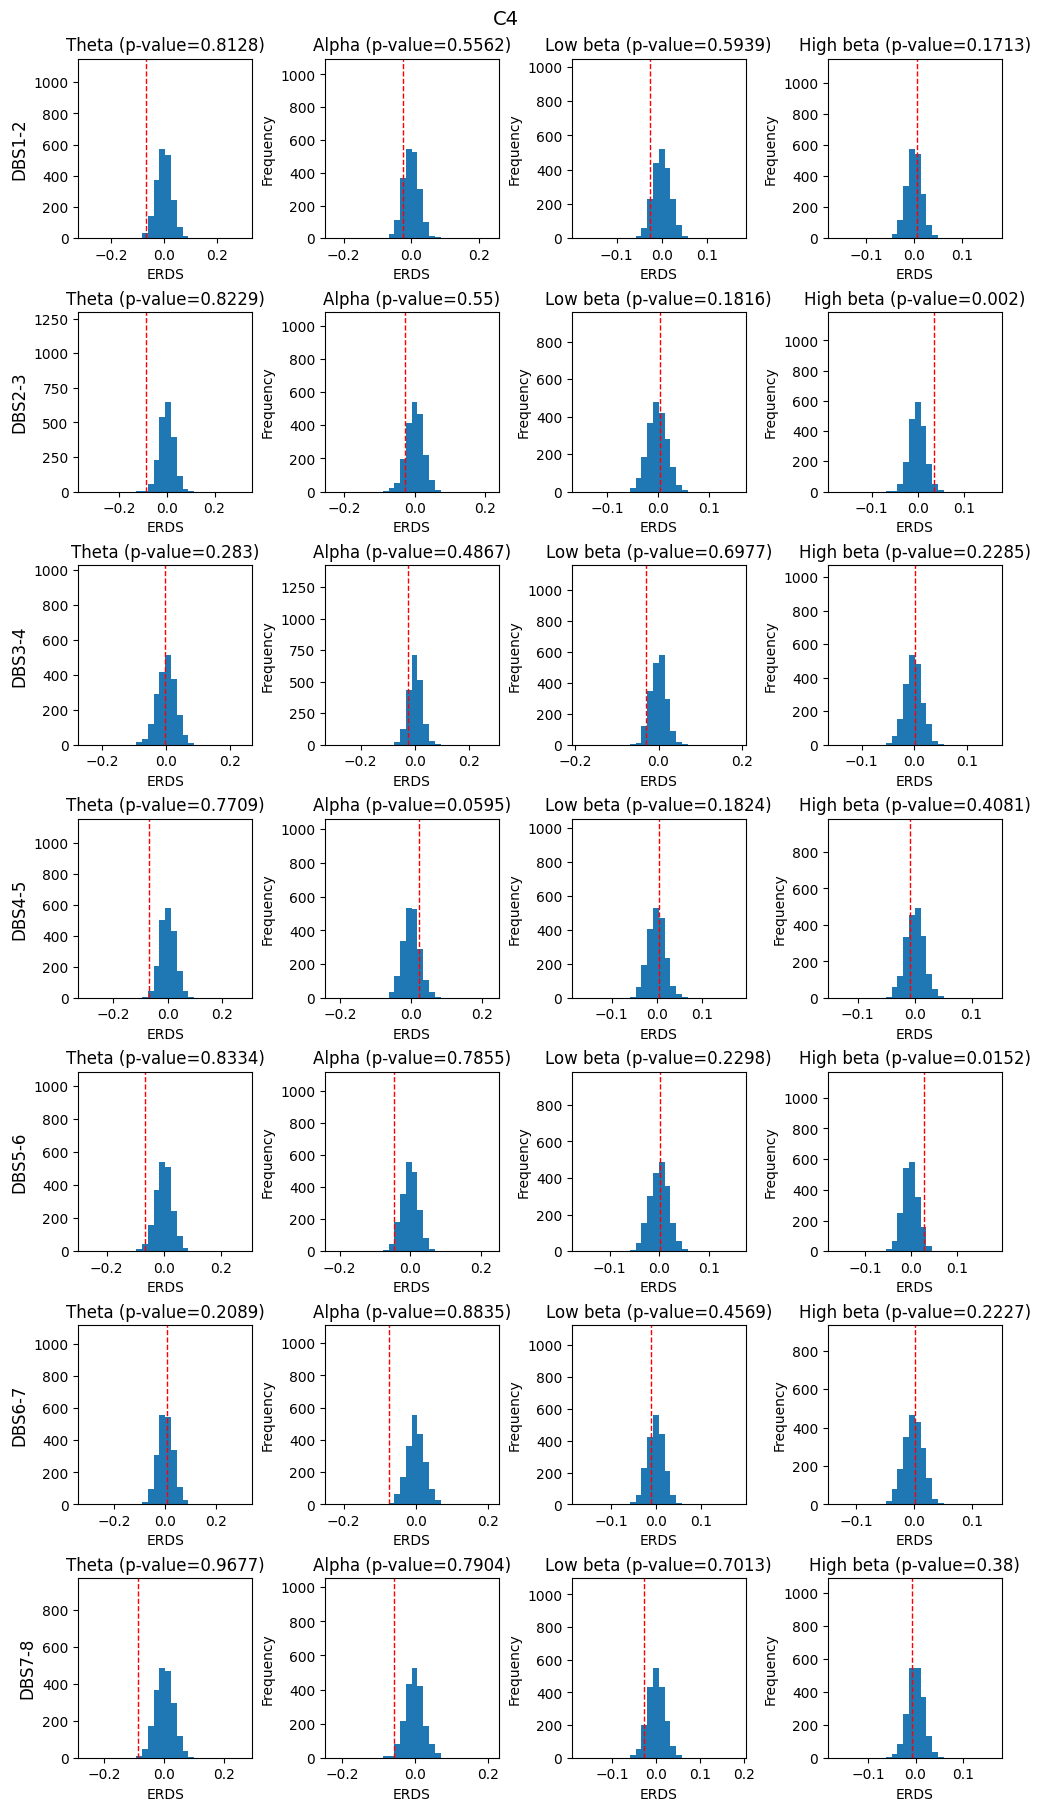

In [123]:
seed_chs = epochs_aff_odd_E.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd_E.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
n_channels = len(epochs_aff_odd_E.copy().pick('eeg').ch_names)
chl_list = ['C4']

fig, axes = plt.subplots(len(seed_chs), 4, figsize=(10,18),layout="constrained")

mask = []

for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    mask1 =[]
    for nfrq, band in enumerate(freq_band):

        mask2 = []
        for nchls, ch in enumerate(chl_list):

          
            values, bins, _ = ax[nfrq].hist(coh_diff_E_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff_E[n_seed, nfrq, nchls, : ][0] <= coh_diff_E_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_E_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff_E[n_seed, nfrq, nchls, : ][0],coh_diff_E_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval_r = 0

            if pval_r <=0.05:
                mask2.append(pval_r)
            else:
                mask2.append(0)

            
            ax[nfrq].axvline(coh_diff_E[n_seed, nfrq, nchls, : ], color='r', linestyle='dashed', linewidth=1)
            ax[nfrq].set_ylabel('Frequency')
            ax[nfrq].set_xlabel('ERDS')

            ax[nfrq].set_title(f'{band} (p-value={pval_r})' )
            ax[nfrq].margins(1, 1)
        ax[0].set_ylabel(seed_ch, size='large')
    
        mask1.append(mask2)
    mask.append(mask1)
mask = np.array(mask)
fig.suptitle(chl_list[0], fontsize=14)


calculating p values

In [124]:
seed_chs = epochs_aff_odd_E.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd_E.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']

pvals = []
for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    pvals1 = [] 
    for nfrq, band in enumerate(freq_band):

        pvals2 = []
        for nchls, ch in enumerate(chl_list):
         
            values, bins = np.histogram(coh_diff_E_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff_E[n_seed, nfrq, nchls, : ][0] <= coh_diff_E_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_E_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff_E[n_seed, nfrq, nchls, : ][0],coh_diff_E_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval = 0
            
            pvals2.append(pval)
        pvals2 = np.array(pvals2).reshape(n_channels,1)
   
        pvals1.append(pvals2)
    pvals.append(pvals1)
pvals = np.array(pvals)


FDR correction for multiple comparison 

In [125]:
alpha = 0.05
pval_bonferroni = []
pval_fdr = []
mask_fdr = []

for nfrq, band in enumerate(freq_band):
    
    pvals_band = pvals[:,nfrq,:,:].flatten()
    reject_bonferroni, p_bon = mne.stats.bonferroni_correction(pvals_band, alpha=alpha)

    reject_fdr, p_fdr = mne.stats.fdr_correction(pvals_band, alpha=alpha, method="indep")

    mask_fdr.append(reject_fdr)
    pval_bonferroni.append(p_bon)
    pval_fdr.append(p_fdr)
           
pval_bonferroni = np.array(pval_bonferroni)
pval_fdr = np.array(pval_fdr)
mask_fdr = np.array(mask_fdr)

pval_fdr = pval_fdr.reshape(pvals.shape)
mask_fdr = mask_fdr.reshape(pvals.shape)

In [126]:
alpha = 0.05
pval_bonferroni = []
pval_fdr = []
mask_fdr = []

for nfrq, band in enumerate(freq_band):
    pval_bonferroni1 = []
    pval_fdr1 = []
    mask_fdr1 = []
    
    for nchls, ch in enumerate(chl_list):
        pvals_band = pvals[:,nfrq,nchls,:]
        n_samples , n_tests = pvals_band.shape
        reject_bonferroni, p_bon = mne.stats.bonferroni_correction(pvals_band, alpha=alpha)

        reject_fdr, p_fdr = mne.stats.fdr_correction(pvals_band, alpha=alpha, method="indep")

        mask_fdr1.append(reject_fdr)
        pval_bonferroni1.append(p_bon)
        pval_fdr1.append(p_fdr)
        
    pval_bonferroni.append(pval_bonferroni1)
    pval_fdr.append(pval_fdr1)
    mask_fdr.append(mask_fdr1)
    
pval_bonferroni = np.rollaxis(np.array(pval_bonferroni),2,0)
pval_fdr = np.rollaxis(np.array(pval_fdr),2,0)
mask_fdr = np.rollaxis(np.array(mask_fdr),2,0)

In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd_E.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff_E[n_ch,n,:,:], epochs_aff_odd_E.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,mask=mask_fdr[n_ch,n,:,:], mask_params=mask_params, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")
masked_coh = mask_fdr*coh_diff

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [109]:
# cluster size thresholding. Selecting clusters with more than 3 electrodes


# check only for ipsilasional channels
masked_coh = np.multiply(mask_fdr,coh_diff_E)

mask_cluster_size = np.zeros(masked_coh.shape)
mask_cluster_vol = np.zeros(masked_coh.shape)

adj, names = mne.channels.find_ch_adjacency(epochs_aff_odd_E.info, 'eeg')

clus_size_thres = 2

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
sig_clus_vol = []
sig_dbs_ch = []
sig_band_ch = []
sig_eeg_ch = []



for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd_E.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd_E.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                # print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    mask_cluster_amp = []
                    mask_cluster_ind = []

                    #print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol.append(sum(mask_cluster_amp)*len(mask_cluster_amp))
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    #print(mask_cluster_ind)
                    #print(sum(mask_cluster_amp))

print(sig_clus_vol)


for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd_E.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd_E.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                #print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    
                    mask_cluster_amp = []
                    mask_cluster_ind = []
                    #print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    #print(mask_cluster_ind)
                    if sig_clus_vol1 == max(sig_clus_vol):
                        
                        sig_eeg_ch_amp = mask_cluster_amp
                        #print(mask_cluster_ind)
                        sig_eeg_ch = mask_cluster_ind
                        for c_ind in mask_cluster_ind:
                            mask_cluster_vol[n_ch,n,c_ind,:] = masked_coh[n_ch,n,c_ind,:]
                            #sig_eeg_ch.append(c_ind)
                        sig_dbs_ch.append(n_ch)
                        sig_band_ch.append(n)
                            
MaxVal, secondMax = sorted(sig_eeg_ch_amp)[-2:]
index_max = sig_eeg_ch_amp.index(MaxVal)
index_secondMax = sig_eeg_ch_amp.index(secondMax)
sig_eeg_ch_best_2 = [sig_eeg_ch[index_max], sig_eeg_ch[index_secondMax]]                  

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 11
[array([0.14566805]), array([0.14566805]), array([0.21601825]), array([0.49436957]), array([0.21653822]), array([0.13908917]), array([0.13908917])]


In [ ]:
sig_clus_vol

In [110]:
sig_eeg_ch

[5, 9, 10]

In [111]:
sig_eeg_ch_best_2

[5, 10]

In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4,8,13,21]
max_freq = [7,12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_size[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [ ]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_vol[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [112]:
print(sig_dbs_ch)
print(sig_band_ch)
print(sig_eeg_ch)
print(sig_eeg_ch_best_2)

sig_eeg = []
for n, i in enumerate(sig_eeg_ch_best_2):
    sig_eeg.append(epochs_aff_odd_E.copy().pick(['eeg']).ch_names[sig_eeg_ch_best_2[n]])


print(sig_eeg)

[2]
[0]
[5, 9, 10]
[5, 10]
['Cz', 'P4']


[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05652075]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05148838]
 [0.05678073]]


C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2459704926.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_all_d = np.zeros(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1],1)
C:\Users\malann\AppData\Local\Temp\ipykernel_239232\2459704926.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_all_d = np.zeros(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1],1)


Text(0.5, 1.0, 'DBS3-4 Theta')

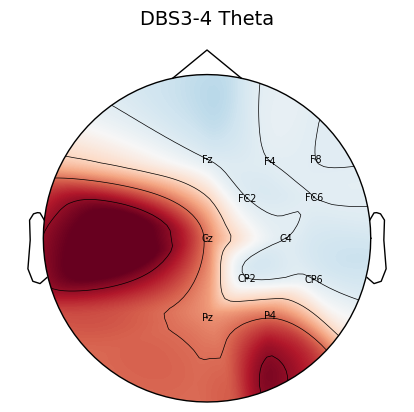

In [113]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

ep_all_d = np.zeros(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd_E.copy().pick('eeg').get_data().shape[1],1)
ep_all = mne.EvokedArray(ep_all_d, epochs_aff_odd_E.copy().pick('eeg').info)


fig, ax = plt.subplots(1,1)
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)


for i, n in enumerate(epochs_aff_odd_E.copy().pick('eeg').ch_names):
    ep_all_d[ep_all.ch_names.index(n)] = mask_cluster_vol[sig_dbs_ch[0],sig_band_ch[0],i,:]


print(ep_all_d)
tfr_evoked = mne.EvokedArray(ep_all_d, epochs_aff_odd_E.copy().pick('eeg').info)
tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5), cmap='RdBu_r', colorbar =False, show=False,image_interp='cubic', extrapolate='head', border='mean', res=64, axes = ax)

ax.set_title(f"{epochs_aff_odd_E.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]} {freq_band[sig_band_ch[0]]}", fontsize=14)


Plot Significant TFR Coherence

In [ ]:
""""Coherence and Granger Causality"""

sig_dbs_ch
sig_eeg_ch_best_2

sig_eeg = []
for n, i in enumerate(sig_eeg_ch_best_2):
    sig_eeg.append(epochs_aff_odd_E.copy().pick(['eeg']).ch_names[sig_eeg_ch_best_2[n]])

ipsi_ch = ['FC2','CP2','C4','CP6','FC6']

#sel_chl = 'ipsi'
if sel_chl == 'ipsi':
    sig_eeg=ipsi_ch
        

epochs_aff_odd2 = epochs_aff_odd_E.copy().pick(sig_eeg)

sig_seed_ch = [epochs_aff_odd_E.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]]

picks = mne.pick_types(epochs_aff_odd_E.info, eeg=True, dbs=False, emg= False,stim=False, eog=False,
                       exclude='bads')

epochs_aff_odd_E.pick(['eeg','dbs'])
epochs_aff_typ_E.pick(['eeg','dbs'])

# Use 'DBS' channels as seed
        
coh_diff_E = []
for seed_ch in sig_seed_ch:
    
    picks_ch_names = epochs_aff_odd_E.ch_names
    # Create seed-target indices for connectivity computation
    seed = np.array([picks_ch_names.index(seed_ch)])
    targets = np.arange(len(picks))
    indices = seed_target_indices(seed, targets)
    
    min_freq = (4, 8,13,21)
    max_freq = (7, 12,20,30)

    
    # Define wavelet frequencies and number of cycles
    cwt_freqs = np.arange(1, 41, 1)
    cwt_n_cycles = 7

    # Run the connectivity analysis using n parallel jobs
    con_odd_E = spectral_connectivity_epochs(
        epochs_aff_odd_E, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    con_typ_E = spectral_connectivity_epochs(
        epochs_aff_typ_E, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    times = con_odd_E.times
    freqs = con_odd_E.freqs

    # Mark the seed channel with a value of 1.0, so we can see it in the plot
    # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
    # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0

    #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
    tfr_odd_E = mne.time_frequency.AverageTFR(epochs_aff_odd_E.copy().pick('eeg').info, con_odd_E.get_data(), times, freqs, len(epochs_aff_odd_E))
    #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

    tfr_typ_E = mne.time_frequency.AverageTFR(epochs_aff_typ_E.copy().pick('eeg').info, con_typ_E.get_data(), times, freqs, len(epochs_aff_typ_E))
    #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
    
    # TFR differences in freq bands and time period 0 to 1.5s

    tfr_diff_E = tfr_odd_E- tfr_typ_E

    # Generate connectivity indices
    target_gc = []
    for i in sig_eeg:
        target_gc.append(picks_ch_names.index(i))
    target_gc = np.array(target_gc)
    
    indices_dbs_eeg = ([seed], [target_gc])  # DBS => EEG
    indices_eeg_dbs = ([target_gc], [seed])  # EEG => DBS

    # Compute Granger Causality DBS => EEG
    
    gc_odd_E_dbs_eeg = spectral_connectivity_epochs(
        epochs_aff_odd_E, method=["gc"], indices=indices_dbs_eeg, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )
    
    gc_typ_E_dbs_eeg = spectral_connectivity_epochs(
        epochs_aff_typ_E, method=["gc"], indices=indices_dbs_eeg, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )
   
    # Compute Granger Causality EEG => DBS
    gc_odd_E_eeg_dbs = spectral_connectivity_epochs(
        epochs_aff_odd_E, method=["gc"], indices=indices_eeg_dbs, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )

    gc_typ_E_eeg_dbs = spectral_connectivity_epochs(
        epochs_aff_typ_E, method=["gc"], indices=indices_eeg_dbs, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )


In [ ]:
tfr_odd_E_dbs_eeg = mne.time_frequency.AverageTFR(epochs_aff_odd_E.copy().pick('Cz').info, gc_odd_E_dbs_eeg.get_data(), times, freqs, len(epochs_aff_odd_E))
#tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_typ_E_dbs_eeg = mne.time_frequency.AverageTFR(epochs_aff_typ_E.copy().pick('Cz').info, gc_typ_E_dbs_eeg.get_data(), times, freqs, len(epochs_aff_typ_E))
#tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_diff_E_dbs_eeg = tfr_odd_E_dbs_eeg- tfr_typ_E_dbs_eeg

tfr_odd_E_eeg_dbs = mne.time_frequency.AverageTFR(epochs_aff_odd_E.copy().pick('Cz').info, gc_odd_E_eeg_dbs.get_data(), times, freqs, len(epochs_aff_odd_E))
#tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_typ_E_eeg_dbs = mne.time_frequency.AverageTFR(epochs_aff_typ_E.copy().pick('Cz').info, gc_typ_E_eeg_dbs.get_data(), times, freqs, len(epochs_aff_typ_E))
#tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_diff_E_eeg_dbs = tfr_odd_E_eeg_dbs- tfr_typ_E_eeg_dbs


In [ ]:
if sel_chl == 'ipsi':
    CCC_E = tfr_diff_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_E_{sub}_{st}_ipsi"
    np.save(file,CCC_E)

    CCC_odd_E = tfr_odd_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_Oddball_E_{sub}_{st}_ipsi"
    np.save(file,CCC_odd_E)

    CCC_typ_E = tfr_typ_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_Standard_E_{sub}_{st}_ipsi"
    np.save(file,CCC_typ_E)

    GC_E_dbs_eeg = tfr_diff_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_E_dbs_eeg_{sub}_{st}_ipsi"
    np.save(file,GC_E_dbs_eeg)

    GC_odd_E_dbs_eeg = tfr_odd_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_dbs_eeg_Oddball_E_{sub}_{st}_ipsi"
    np.save(file,GC_odd_E_dbs_eeg)

    GC_typ_E_dbs_eeg = tfr_typ_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_dbs_eeg_Standard_E_{sub}_{st}_ipsi"
    np.save(file,GC_typ_E_dbs_eeg)


    GC_E_eeg_dbs = tfr_diff_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_{sub}_{st}_ipsi"
    np.save(file,GC_E_eeg_dbs)

    GC_odd_E_eeg_dbs = tfr_odd_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_Oddball_{sub}_{st}_ipsi"
    np.save(file,GC_odd_E_eeg_dbs)

    GC_typ_E_eeg_dbs = tfr_typ_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_Standard_{sub}_{st}_ipsi"
    np.save(file,GC_typ_E_eeg_dbs)

        
else:

    CCC_E = tfr_diff_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_E_{sub}_{st}"
    np.save(file,CCC_E)

    CCC_odd_E = tfr_odd_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_Oddball_E_{sub}_{st}"
    np.save(file,CCC_odd_E)

    CCC_typ_E = tfr_typ_E.copy().pick(sig_eeg).data.mean(axis=0)
    file = f"{base_dir}CCC_Standard_E_{sub}_{st}"
    np.save(file,CCC_typ_E)

    GC_E_dbs_eeg = tfr_diff_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_E_dbs_eeg_{sub}_{st}"
    np.save(file,GC_E_dbs_eeg)

    GC_odd_E_dbs_eeg = tfr_odd_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_dbs_eeg_Oddball_E_{sub}_{st}"
    np.save(file,GC_odd_E_dbs_eeg)

    GC_typ_E_dbs_eeg = tfr_typ_E_dbs_eeg.data.mean(axis=0)
    file = f"{base_dir}GC_dbs_eeg_Standard_E_{sub}_{st}"
    np.save(file,GC_typ_E_dbs_eeg)


    GC_E_eeg_dbs = tfr_diff_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_{sub}_{st}"
    np.save(file,GC_E_eeg_dbs)

    GC_odd_E_eeg_dbs = tfr_odd_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_Oddball_{sub}_{st}"
    np.save(file,GC_odd_E_eeg_dbs)

    GC_typ_E_eeg_dbs = tfr_typ_E_eeg_dbs.data.mean(axis=0)
    file = f"{base_dir}GC_E_eeg_dbs_Standard_{sub}_{st}"
    np.save(file,GC_typ_E_eeg_dbs)


In [ ]:
freqs = con_odd_E.freqs
fig, axis = plt.subplots(1, 1)

tmin = 600
tmax = 900

axis.plot(freqs, CCC_odd_E[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, CCC_typ_E[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball Response', 'Standard'])
fig.suptitle("CCC")

In [ ]:
freqs = con_odd_E.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, CCC_E.mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("CCC: Oddball Response - Standard")

In [ ]:
freqs = gc_odd_E_dbs_eeg.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_odd_E_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_typ_E_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball Response', 'Standard'])
fig.suptitle("GC: [dbs => eeg]")

In [ ]:
freqs = gc_odd_E_eeg_dbs.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_odd_E_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_typ_E_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball Response', 'Standard'])
fig.suptitle("GC: [eeg => dbs]")

In [ ]:
freqs = gc_odd_E_dbs_eeg.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_E_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_E_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)



axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(["GC: [dbs => eeg]", "GC: [eeg => dbs]"])
fig.suptitle('Oddball Response- Standard')

In [ ]:
# creating a mask to plot on tfr coherence betwwn 0s and 1.5s and significant freq band
tmin = -1
tmax = 3

tmin_mark = tmin_coh_lst[3]
tmax_mark = tmax_coh_lst[3]
fmin_mark = min_freq[sig_band_ch[0]]
fmax_mark = max_freq[sig_band_ch[0]]

mask_tfr_diff = np.full(tfr_diff_E.copy().crop(tmin,tmax).pick(sig_eeg).data.shape, False)


for n in range(0,tfr_diff_E.copy().crop(tmin,tmax).data.shape[1]):
    for m in range(0,tfr_diff_E.copy().crop(tmin,tmax).data.shape[2]):
        if n>fmin_mark and n<fmax_mark and m > (tmin_mark-tmin)*200 and m < (tmax_mark-tmin)*200:
            mask_tfr_diff[:,n,m]= True
            
vmax=0.2
vmin=-0.2
fig, axes = plt.subplots(figsize=(5.5, 2.5*len(sig_eeg_ch_best_2)), nrows=len(sig_eeg_ch_best_2), ncols=1, layout="constrained")
    
title = "GC: [dbs => eeg]"
tfr_diff_E_dbs_eeg.plot('Cz', tmin=tmin,tmax=tmax, axes = axes[0], vmax=vmax,vmin=vmin, mask =mask_tfr_diff[0,:,:] ,mask_style = 'contour', show= False)
axes[0].set_title(title)

title = "GC: [eeg => dbs]"
tfr_diff_E_eeg_dbs.plot("Cz", tmin=tmin,tmax=tmax, axes = axes[1], vmax=vmax,vmin=vmin, mask =mask_tfr_diff[0,:,:] ,mask_style = 'contour', show= False)
axes[1].set_title(title)

In [ ]:
# creating a mask to plot on tfr coherence betwwn 0s and 1.5s and significant freq band
tmin = -1
tmax = 3

tmin_mark = tmin_coh_lst[3]
tmax_mark = tmax_coh_lst[3]
fmin_mark = min_freq[sig_band_ch[0]]
fmax_mark = max_freq[sig_band_ch[0]]

mask_tfr_diff = np.full(tfr_diff_E.copy().crop(tmin,tmax).pick(sig_eeg).data.shape, False)


for n in range(0,tfr_diff_E.copy().crop(tmin,tmax).data.shape[1]):
    for m in range(0,tfr_diff_E.copy().crop(tmin,tmax).data.shape[2]):
        if n>fmin_mark and n<fmax_mark and m > (tmin_mark-tmin)*200 and m < (tmax_mark-tmin)*200:
            mask_tfr_diff[:,n,m]= True
            
vmax=0.5
vmin=-0.5
fig, axes = plt.subplots(figsize=(5.5, 2.5*len(sig_eeg)), nrows=len(sig_eeg), ncols=1, layout="constrained")

if len(sig_eeg_ch)>1:
    for i, (ax, ch) in enumerate(zip(axes, tfr_diff_E.copy().pick(sig_eeg).ch_names)):
        title = 'Oddball Response - Standrad:' + seed_ch +' vs '+ch 
        tfr_diff_E.plot(ch, tmin=tmin,tmax=tmax, axes = ax, vmax=vmax,vmin=vmin, mask =mask_tfr_diff[i,:,:] ,mask_style = 'contour', show= False)
        ax.set_title(title)
else:
    title = 'Oddball Response - Standrad:' + seed_ch +' vs '+ sig_eeg[0]
    tfr_diff_E.plot(sig_eeg[0], tmin=tmin,tmax=tmax, axes = axes, vmax=vmax,vmin=vmin, mask =mask_tfr_diff[0,:,:] ,mask_style = 'contour', show= False)
    axes.set_title(title)

Coherence Excel sheet 

In [ ]:
df = tfr_typ_E_dbs_eeg.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["DBS=> EEG"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]

if sub == '007':
    df_mean.to_csv(base_dir+'Oddball_GC_data_E_NE4.csv', mode='a', index=False, header=header)
else:
    df_mean.to_csv(base_dir+'Oddball_GC_data_E_NE4.csv', mode='a', index=False, header=False)


df = tfr_odd_E_dbs_eeg.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball Response'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["DBS=> EEG"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data_E_NE4.csv', mode='a', index=False, header=False)





In [ ]:
df = tfr_typ_E_eeg_dbs.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["EEG=> DBS"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data_E_NE4.csv', mode='a', index=False, header=False)



df = tfr_odd_E_eeg_dbs.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball Response'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["EEG=> DBS"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data_E_NE4.csv', mode='a', index=False, header=False)





In [ ]:
df = tfr_typ_E.copy().pick(sig_eeg).to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


df_mean = (
    df.groupby(["Time_dur", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "EEG", "CCC"]


if sub == '007':
    df_mean.to_csv(base_dir+'Oddball_Coh_data_E_NE4.csv', mode='a', index=False, header=header)
else:
    df_mean.to_csv(base_dir+'Oddball_Coh_data_E_NE4.csv', mode='a', index=False, header=False)



df = tfr_odd_E.copy().pick(sig_eeg).to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


df_mean = (
    df.groupby(["Time_dur", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball Response'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])


df_mean.to_csv(base_dir+'Oddball_Coh_data_E_NE4.csv', mode='a', index=False, header=False)
